# Using Pysersic for simple fits at maximum speed 

The main strength of `pysersic` is its ability to provide performant estimates (or direct samples) of the posterior on the parameters which define a parametric profile of choice vis a vis a galaxy image. 

That said, the techinques we have employed under the hood to make rendering model images as speedy as possible means that `pysersic` can technically also be used to simply minimize the `chi2` and get a single answer out. 

To this end, we have recently added in the ability to use `pysersic` in this way, which in most cases should be relatively straightforward. For now, these routines are kept separate from the core `pysersic` infrastructure, and not all modes of fitting are supported --- in this initial release, only fitting single objects with Sersic and point-source profiles are supported. 

We plan to gradually expand the capabilities herein to include scene fitting and all supported profiles, as well as to potentially integrate the "fast fit" code into the rest of `pysersic`, so stay tuned for that (but it is not the highest priority on the roadmap). 

In this walk through, we'll cover how to simply load up and fit an image as quickly as possible. As usual, we'll start by loading up our example galaxy:


In [1]:
import numpy as np


def load_data(n):
    im = np.load(f"examp_gals/gal{n}_im.npy")
    mask = np.load(f"examp_gals/gal{n}_mask.npy")
    sig = np.load(f"examp_gals/gal{n}_sig.npy")
    psf = np.load(f"examp_gals/gal{n}_psf.npy")
    return im, mask, sig, psf


im, mask, sig, psf = load_data(2)

Next, we'll load the `FastRenderer` (a pared down version of our other renderers) and the `FitSingleMAP` object:

In [2]:
from pysersic.map import FitSingleMAP, FastRenderer

We can then initialize our `FitSingleMAP` object with the data and the renderer.

In [3]:
fitter = FitSingleMAP(data=im, sig=sig, psf=psf, mask=mask, renderer=FastRenderer)

To fit, we simply call the `.fit()` method. It uses the `SourceProperties` object, much like our `autoprior`, to determine a reasonable starting point and bounds for the minimization. We plan to allow you to pass initial params and bounds manually if you wish in the near future. 

In [4]:
best_params = fitter.fit()

Notice that for this example (cutout of ~100x100 pixels), the entire fit took less than half a second.

Here, we dispense with fancy results objects and simply return an array of best-fit parameters, which is a simple array containing: 
```
[xc, yc, flux, r_eff, e1, e2,n]
```
where `e1` and `e2` are a parameterization of the ellipticity and position angle. These can be converted to the more standard ellipticity and theta via a static method of the `FastRenderer`, passing an `r_eff`, and the `e1` and `e2`. The `r_eff` output is the same as the input, but is needed to perform the conversion.

In [5]:
FastRenderer.convert_params(best_params[3], best_params[4], best_params[5])

(Array(5.7158976, dtype=float32),
 Array(0.323247, dtype=float32),
 Array(-0.7017054, dtype=float32))

Which correspond to `r_eff`, `ellip`, and `theta` (in radians), respectively. 

We can use the fitter to create a model from our best-fitting parameters and compare to the data: 

In [6]:
model_image = fitter.create_model(best_params)

In [7]:
# define some plotting tools
import matplotlib.pyplot as plt


def plot_mod_data(im, model, mask=None):
    # plot the observed data, the model, and the residuals
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Observed data
    vmin, vmax = np.percentile(im, [1, 99])
    if mask is not None:
        axs[0].imshow(
            np.ma.masked_array(im, mask=mask),
            origin="lower",
            cmap="gray_r",
            vmin=vmin,
            vmax=vmax,
        )
    else:
        axs[0].imshow(im, origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax)
    axs[0].set_title("Observed Data")

    # Model
    if mask is not None:
        axs[1].imshow(
            np.ma.masked_array(model, mask=mask),
            origin="lower",
            cmap="gray_r",
            vmin=vmin,
            vmax=vmax,
        )
    else:
        axs[1].imshow(model, origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax)
    axs[1].set_title("Fitted Model")

    # Residuals
    residuals = im - model
    if mask is not None:
        axs[2].imshow(
            np.ma.masked_array(residuals, mask=mask),
            origin="lower",
            cmap="RdBu",
            vmin=-1,
            vmax=1,
        )
    else:
        axs[2].imshow(residuals, origin="lower", cmap="RdBu", vmin=-1, vmax=1)
    axs[2].set_title("Residuals")

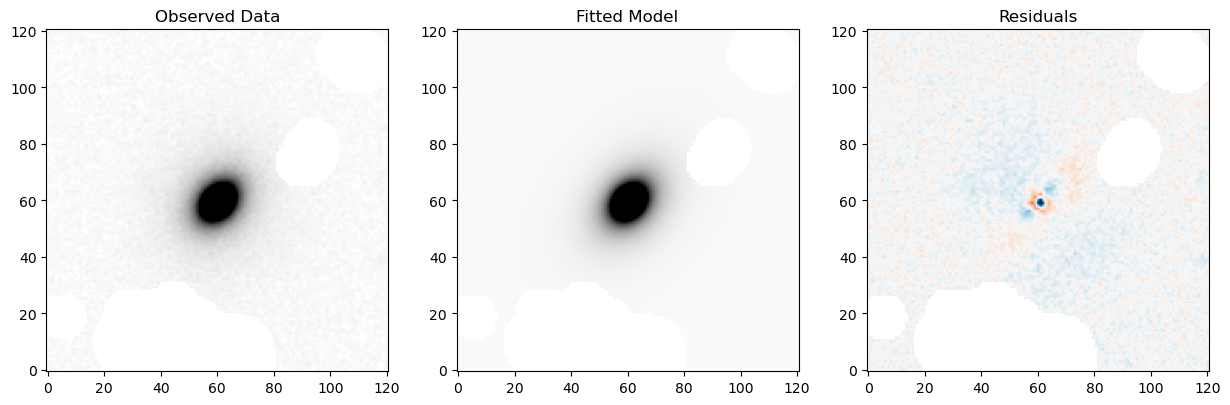

In [8]:
plot_mod_data(im, model_image, mask)